In [1]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(viridis)

Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: viridisLite




NESC RSPO3 DIRAS3  NESC RSPO3 TEX15     oRG HOPX APOE      oRG HOPX TNC 
              946              2852              4704              5102 
  RGC FABP7 PMP22   tRG CRYAB FNDC1    tRG CRYAB MEST   vRG HMGA2 CCND1 
             1464               581              2054             18845 
   vRG SAT1 STMN2 
            13233 

`summarise()` has grouped output by 'cbnage'. You can override using the `.groups` argument.



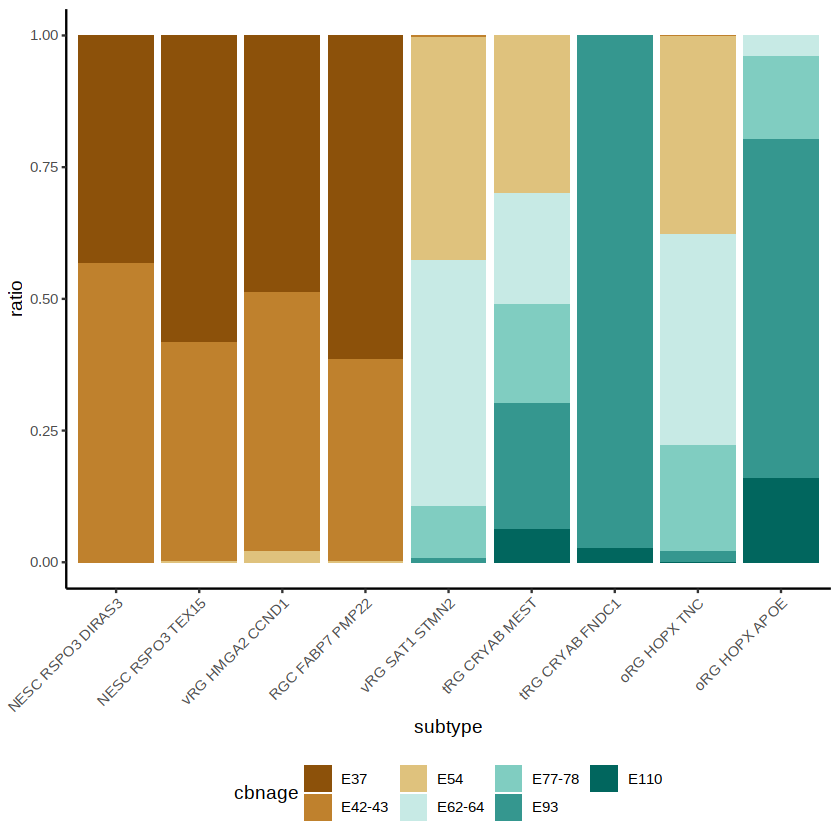

In [2]:
## Plot age proportions for macaque subtypes
fmeta <- readRDS(file = paste0("../../MF1/overview/load_files/Reanno_E37-110.org.meta.10052022.rds"))

## Subset to RGC ells
rgc_cls <- c("NESC RSPO3 DIRAS3", "NESC RSPO3 TEX15", 
             "vRG HMGA2 CCND1", "RGC FABP7 PMP22", 
             "vRG SAT1 STMN2", "tRG CRYAB MEST", "tRG CRYAB FNDC1", ##"Ependymal FOXJ1", 
             "oRG HOPX TNC", "oRG HOPX APOE")
rgcmeta <- fmeta[fmeta$subtype %in% rgc_cls, ]
table(rgcmeta$subtype)


## Plot the props
age_cols <- c("#8c510a", "#bf812d", "#dfc27d", "#c7eae5", "#80cdc1", "#35978f", "#01665e") %>% 
            setNames(., c("E37", "E42-43", "E54", "E62-64", "E77-78", "E93", "E110"))

pdata_mac_prop <- rgcmeta %>%
            group_by(cbnage, subtype, .drop = FALSE) %>%
            summarize(ncells = n()) %>%
            ungroup() %>%
            group_by(subtype) %>%
            mutate(ratio = ncells/sum(ncells)) %>%
            mutate(subtype = factor(subtype, levels = rgc_cls)) %>%
            mutate(cbnage = factor(cbnage, levels = names(age_cols)))

p_mac_prop <- ggplot(pdata_mac_prop, aes(x = subtype, y = ratio, fill = cbnage)) +
            geom_bar(position = "stack", stat = "identity") +
            scale_fill_manual(values = age_cols) +
            theme_classic() +
            RotatedAxis(legend.position = "bottom")
p_mac_prop

In [3]:
##------------------------------------------------------------------------------------------------------
## Comparison with Kriegstein 2017 Science dataset


## system("cp ~/project/public_data/Kriegstein_Science_2017/Kriegstein_Science2017_seu.rds ./load_files/")
kri <- readRDS("./load_files/Kriegstein_Science2017_seu.rds")
kri_order <- c("RG-early", "vRG", "tRG", "oRG")
kri <- subset(kri, WGCNAcluster %in% kri_order)
Idents(kri) <- "WGCNAcluster"

`summarise()` has grouped output by 'cbnage'. You can override using the `.groups` argument.



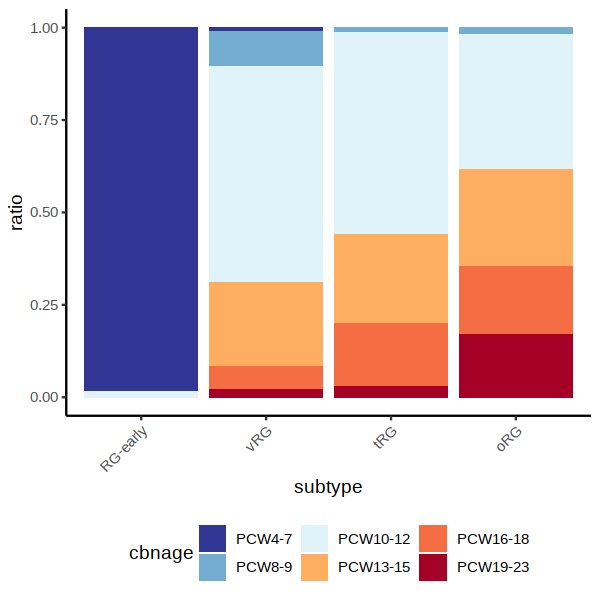

In [4]:
## Plot the age proportions of different human RGC subtypes
#age_cols <- c("#dfc27d", "#c7eae5", "#80cdc1", "#35978f", "#01665e") %>% 
age_cols <- c("#313695", "#74add1", "#e0f3f8", "#fdae61", "#f46d43", "#a50026", "#a50026") %>%
            setNames(., c("PCW4-7", "PCW8-9", "PCW10-12", "PCW13-15", "PCW16-18", "PCW19-23", "PCW24-38"))
pdata <- kri@meta.data %>%
            mutate(pcw = Age_in_Weeks - 2) %>%
            mutate(cbnage = case_when(
                pcw < 8 ~ "PCW4-7", #P1
                pcw >=8 & pcw < 10 ~ "PCW8-9", #P2
                pcw >=10 & pcw < 13 ~ "PCW10-12", #P3
                pcw >=13 & pcw < 16 ~ "PCW13-15", #P4
                pcw >=16 & pcw < 19 ~ "PCW16-18", #P5
                pcw >=19 & pcw < 24 ~ "PCW19-23", #P6
                pcw >=24 & pcw < 38 ~ "PCW24-38") #P7
                   )
pdata_k2017_prop <- pdata %>%
            mutate(subtype = WGCNAcluster) %>%
            group_by(cbnage, subtype, .drop = FALSE) %>%
            summarize(ncells = n()) %>%
            ungroup() %>%
            group_by(subtype) %>%
            mutate(ratio = ncells/sum(ncells)) %>%
            mutate(subtype = factor(subtype, levels = kri_order)) %>%
            mutate(cbnage = factor(cbnage, levels = names(age_cols)))

p_k2017_prop <- ggplot(pdata_k2017_prop, aes(x = subtype, y = ratio, fill = cbnage)) +
            geom_bar(position = "stack", stat = "identity") +
            scale_fill_manual(values = age_cols) +
            theme_classic() +
            RotatedAxis(legend.position = "bottom")
options(repr.plot.width=5, repr.plot.height=5, res = 300)
##pdf(paste0("./report/", "MatchPublic.Kriegstein.Science2017.subtype_age_prop.pdf"))
print(p_k2017_prop)
##dev.off()

In [5]:
### human data avgs & markers
Idents(kri) <- "WGCNAcluster"
avgs_kri <- lapply(kri_order, function(cls) {
        subctx <- kri$RNA@data[, kri@meta.data$WGCNAcluster == cls, drop = FALSE]
        avg <- log(Matrix::rowMeans(subctx) + 1)
        avg
        }) %>%
        setNames(., kri_order) %>%
        as.data.frame(., check.names = FALSE) %>%
        as.matrix()

mars_human <- FindAllMarkers(kri, only.pos=TRUE, logfc.threshold = 0.4, min.pct = 0.1) %>%
        .$gene %>% unique()

Calculating cluster tRG

Calculating cluster vRG

Calculating cluster oRG

Calculating cluster RG-early



In [6]:
### Rhesus macaque avgs & markers
load(file = paste0("./load_files/intermediate/", "Ptime_mars_cbn_step1.Rdata"))
## res_list, mars_early, mars_org, mars_trg, 
mars_monkey <- c(mars_early, mars_org, mars_trg) %>% unlist() %>% unique()


# Load data
rgc <- readRDS(file = paste0("./load_files/", "RGC_filtered_seu_04112022.rds"))
#rm_cells <- rownames(rgc@meta.data)[rgc@meta.data$cluster == "tRG CRYAB MEST" & 
#rgc@meta.data$cbnage %in% c("E93", "E110")]
#rgc <- rgc[, setdiff(colnames(rgc), rm_cells)]

Idents(rgc) <- "cluster"
avgs_rgc <- log(AverageExpression(rgc)$RNA + 1)
rgc_order <- c("NEP RSPO3 DIRAS3", "NEP RSPO3 TEX15", "vRG HMGA2 CCND1", "RGC FABP7 PMP22", 
               "vRG SAT1 STMN2", "tRG CRYAB MEST", "tRG CRYAB FNDC1", "oRG HOPX TNC", "oRG HOPX APOE")#"Ependymal", 

Finished averaging RNA for cluster RGC FABP7 PMP22

Finished averaging RNA for cluster vRG HMGA2 CCND1

Finished averaging RNA for cluster NEP RSPO3 TEX15

Finished averaging RNA for cluster NEP RSPO3 DIRAS3

Finished averaging RNA for cluster vRG SAT1 STMN2

Finished averaging RNA for cluster oRG HOPX TNC

Finished averaging RNA for cluster tRG CRYAB MEST

Finished averaging RNA for cluster oRG HOPX APOE

Finished averaging RNA for cluster Ependymal

Finished averaging RNA for cluster tRG CRYAB FNDC1



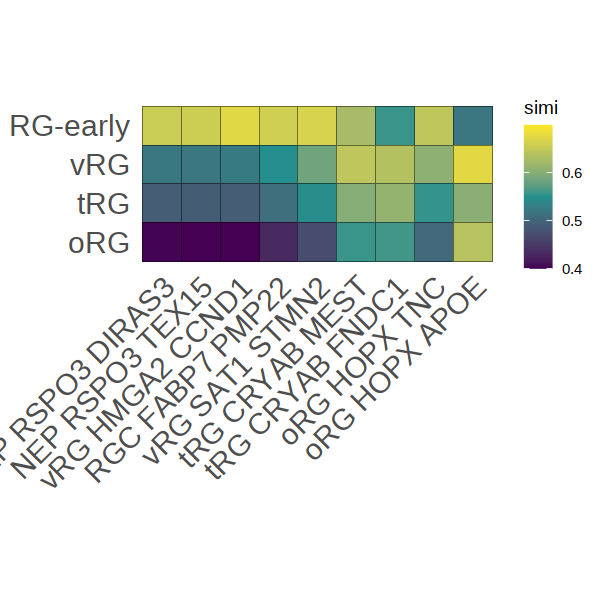

In [7]:
gene_use <- union(mars_human, mars_monkey) %>%
            intersect(., intersect(rownames(avgs_kri), rownames(avgs_rgc)))
heat_data <- cor(avgs_kri[gene_use, ], avgs_rgc[gene_use, ], method = "p") %>%
                reshape2::melt() %>%
                setNames(., c("kridata", "mondata", "simi")) %>%
                filter(kridata %in% kri_order & mondata %in% rgc_order) %>%
                mutate(kridata = factor(as.character(kridata), levels = rev(kri_order))) %>%
                mutate(mondata = factor(as.character(mondata), levels = rgc_order))
heat_data$simi[heat_data$simi > 0.7] <- 0.7
heat_data$simi[heat_data$simi < 0.4] <- 0.4

pheat1 <- ggplot(heat_data, aes_string(x = "mondata", y = "kridata", fill = "simi")) +
                geom_tile(width = 1, height = 1, size = 0.1, color = "black") +
                scale_fill_gradientn(colors = viridis(3), limits = c(0.4, 0.7)) +
                theme_classic() +
                RotatedAxis() + 
                coord_fixed() +
                theme(legend.position = "right", 
                      axis.text.x = element_text(size = rel(2)), 
                      axis.line = element_blank(), 
                      axis.ticks = element_blank(), 
                      axis.title = element_blank(), 
                      axis.text.y = element_text(size = rel(2)))

pheat1
##pdf(paste0(outputdir, "MatchPublic.Kriegstein.Science2017.heatmap.pdf"), width = 7, height = 5)
##pheatmap::pheatmap(cor_mat[kri_order, rgc_order], 
##cluster_rows =FALSE, cluster_cols = FALSE, 
##color = colorRampPalette(viridis::viridis(3))(30), border_color = NA, 
##show_rownames = TRUE, show_colnames = TRUE, fontsize_col = 5, fontsize_row = 8)
##print(pheat)
##dev.off() 

In [8]:
##------------------------------------------------------------------------------------------------------
## Comparison with Kriegstein 2017 Science dataset
#system("cp ~/project/public_data/Kriegstein_Lab/Bhaduri_2021_Nature/Bhaduri_NCX_RGC_seu.rds ./load_files")

bhaduri <- readRDS("./load_files/Bhaduri_NCX_RGC_seu.rds")
bhaduri@meta.data$subtype <- bhaduri@meta.data$CombinedCluster...Final
all_cls <- levels(as.factor(bhaduri@meta.data$subtype))
avgs_bhaduri <- lapply(all_cls, function(cls) {
        subctx <- bhaduri$RNA@data[, bhaduri@meta.data$subtype == cls, drop = FALSE]
        avg <- log(Matrix::rowMeans(subctx) + 1)
        avg
        }) %>%
        setNames(., all_cls) %>%
        as.data.frame(., check.names = FALSE) %>%
        as.matrix()

Idents(bhaduri) <- "subtype"
mars_bhaduri <- FindAllMarkers(bhaduri, only.pos=TRUE, 
                               logfc.threshold = 0.1, min.pct = 0.1, max.cells.per.ident = 500) %>%
        filter(p_val_adj <= 0.01) %>%
        .$gene %>% unique()

Calculating cluster RG_combo2_10

Calculating cluster RG_combo2_9

Calculating cluster RG_combo2_8

Calculating cluster RG_combo2_11

Calculating cluster RG_combo2_6

Calculating cluster RG_combo2_4

Calculating cluster RG_combo2_7

Calculating cluster RG_combo2_2

Calculating cluster RG_combo2_3

Calculating cluster RG_combo2_5

Calculating cluster RG_combo2_1

Calculating cluster RG_combo2_16

Calculating cluster RG_combo2_17

Calculating cluster RG_5

Calculating cluster RG_combo2_13

Calculating cluster RG_combo2_14

Calculating cluster RG_2

Calculating cluster RG_combo2_12

Calculating cluster RG_combo2_15

Calculating cluster RG_combo2_18

Calculating cluster RG_45



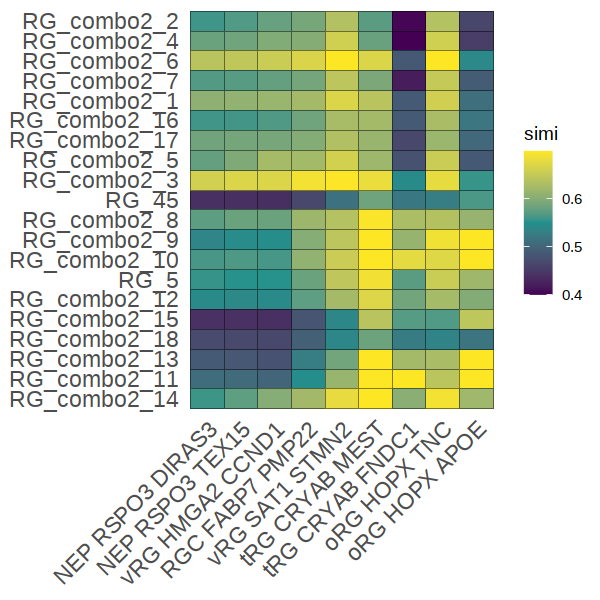

In [11]:
gene_use <- union(mars_bhaduri, mars_monkey) %>%
                intersect(., intersect(rownames(avgs_bhaduri), rownames(avgs_rgc)))
bhaduri_order <- aggregate(Age ~ subtype, bhaduri@meta.data, mean) %>%
                arrange(Age) %>%
                .$subtype %>%
                setdiff(., "RG_2") ## RG_2 is Empendymal
heat_data <- cor(avgs_bhaduri[gene_use, ], avgs_rgc[gene_use, ], method = "p") %>%
                reshape2::melt() %>%
                setNames(., c("bhaduridata", "mondata", "simi")) %>%
                filter(bhaduridata %in% bhaduri_order & mondata %in% rgc_order) %>%
                mutate(bhaduridata = factor(as.character(bhaduridata), levels = rev(bhaduri_order))) %>%
                mutate(mondata = factor(as.character(mondata), levels = rgc_order))
heat_data$simi[heat_data$simi > 0.7] <- 0.7
heat_data$simi[heat_data$simi < 0.4] <- 0.4

pheat2 <- ggplot(heat_data, aes_string(x = "mondata", y = "bhaduridata", fill = "simi")) +
                geom_tile(width = 1, height = 1, size = 0.1, color = "black") +
                scale_fill_gradientn(colors = viridis(3), limits = c(0.4, 0.7)) +
                theme_classic() +
                RotatedAxis() + 
                ##coord_fixed() +
                theme(legend.position = "right", 
                      axis.text.x = element_text(size = rel(1.5)), 
                      axis.line = element_blank(), 
                      axis.ticks = element_blank(), 
                      axis.title = element_blank(), 
                      axis.text.y = element_text(size = rel(1.5)))
pheat2

In [12]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server 7.9 (Maipo)

Matrix products: default
BLAS:   /gpfs/ycga/home/sm2726/packages/R_versions/R-3.6.1/lib64/R/lib/libRblas.so
LAPACK: /gpfs/ycga/home/sm2726/packages/R_versions/R-3.6.1/lib64/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] viridis_0.5.1     viridisLite_0.3.0 ggplot2_3.3.0     dplyr_1.0.7      
[5] Seurat_3.1.5     

loaded via a namespace (and not attached):
 [1] nlme_3.1-147        tsne_0.1-3          Rcpp